# Assignment 04. Classical, ML, and Deep Learning Approaches to Microscopy Analysis

##### Elise M. Etrheim
20 February 2026

## Task 1. Classical Image Analysis Pipeline

### Part A. Setup and Configuration

In [66]:
# Import foundational libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray

# Suppress KMeans MKL warning (Task 2)
import os
os.environ["OMP_NUM_THREADS"] = "3"
os.environ["MKL_NUM_THREADS"] = "3"

# Reproducibility & display niceties
np.random.seed(0)
plt.rcParams["figure.dpi"] = 120

# Paths
RAW_DIR = Path("raw_data") # the local DOPAD folder
OUT_DIR = Path("assignment_04_output") # where the CSV + figures will be saved
OUT_DIR.mkdir(exist_ok=True)

# How many images to process for Task 1 pipeline
N_IMAGES = 100

### Part B. Collect Image Filepaths

In [67]:
exts = ["*.png"]

image_paths = []
for ext in exts:
    image_paths += sorted(RAW_DIR.glob(ext))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found in {RAW_DIR.resolve()}")

print("Found images:", len(image_paths))
print("First 5:", [p.name for p in image_paths[:5]])

# Use the defined subset for this assignment task
image_paths = image_paths[:min(N_IMAGES, len(image_paths))]
print("Using images:", len(image_paths))

Found images: 201
First 5: ['11500X00.png', '11500X01.png', '11500X02.png', '11500X03.png', '11500X04.png']
Using images: 100


### Part C. Helper Functions

In [68]:
from typing import Dict, Tuple
from skimage.filters import threshold_otsu, median
from skimage.morphology import disk, remove_small_objects, remove_small_holes
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import exposure
from scipy import ndimage as ndi
from skimage.measure import regionprops_table

def load_grayscale_float01(path: Path) -> np.ndarray:
    """
    Load an image, convert to grayscale if needed, return float image in [0, 1].
    Handles RGBA/RGB and already-grayscale images.
    """
    img = imread(path)

    # If RGBA/RGB, drop alpha if present and convert to grayscale
    if img.ndim == 3:
        if img.shape[-1] == 4:
            img = img[..., :3]
        img = rgb2gray(img) # returns float in [0,1] for uint inputs

    # Ensure float in [0,1]
    img = img.astype(np.float64, copy=False)
    if img.max() > 1.0:
        img = (img - img.min()) / (img.max() - img.min() + 1e-12)

    return img

def compute_snr_mu_over_sigma(img01: np.ndarray) -> float: 
    """SNR = μ/σ (assignment definition)."""
    mu = float(np.mean(img01))
    sigma = float(np.std(img01))
    return np.inf if sigma == 0 else mu / sigma

def denoise_median(img01: np.ndarray, radius: int = 2) -> np.ndarray:
    """Median filter using a disk footprint."""
    return median(img01, footprint=disk(radius))

def apply_clahe(img01: np.ndarray, clip_limit: float = 0.02) -> np.ndarray:
    """
    CLAHE contrast enhancement (required to show per assignment).
    clip_limit should be in 0.01-0.03 range, but will later be rejected.
    """
    return exposure.equalize_adapthist(img01, clip_limit=clip_limit)

def segment_otsu_watershed_dark_particles(
    img01: np.ndarray,
    min_size: int = 50,
    hole_area: int = 50, 
    dist_smooth_sigma: float = 1.0,
    min_distance: int = 10,
    footprint_size: int = 9,
) -> np.ndarray: 
    """
    Otsu + Watershed for DARK particles on BRIGHT background.
    Returns: 
        labels. int array where 0=background and 1..N are particle labels
    """
    t = threshold_otsu(img01)
    particles = img01 < t # inversion for dark particles

    # Light cleanup for watershed stability (implementation detail)
    particles = remove_small_objects(particles, min_size=min_size)
    particles = remove_small_holes(particles, area_threshold=hole_area)

    # Distance transform + slight smoothing to suppress spurious maxima
    dist = ndi.distance_transform_edt(particles)
    dist_s = gaussian(dist, sigma=dist_smooth_sigma, preserve_range=True)

    coords = peak_local_max(
        dist_s,
        labels=particles,
        min_distance=min_distance,
        footprint=np.ones((footprint_size, footprint_size), dtype=bool),
    )

    markers = np.zeros(dist.shape, dtype=int)
    if coords.size > 0: 
        markers[tuple(coords.T)] = np.arange(1, coords.shape[0] + 1)

    labels = watershed(-dist_s, markers, mask=particles)
    return labels

def measure_particles(labels: np.ndarray, intensity_img: np.ndarray) -> pd.DataFrame:
    """
    Measure morphology with regionprops_table.
    intensity_img should match segmentation image (typically denoised).
    """
    props = regionprops_table(
        labels, 
        intensity_image=intensity_img,
        properties=[
            "label",
            "area",
            "perimeter",
            "equivalent_diameter",
            "eccentricity",
            "solidity",
            "mean_intensity",
            "intensity_std",
        ],
    )
    return pd.DataFrame(props)

### Part D. Representative Walkthrough

Representative image: 11500X00.png
SNR raw:   4.853
SNR median:4.864

Otsu threshold (median): 0.6738  → particles found: 8
Otsu threshold (CLAHE 0.02): 0.6504  → particles found: 29



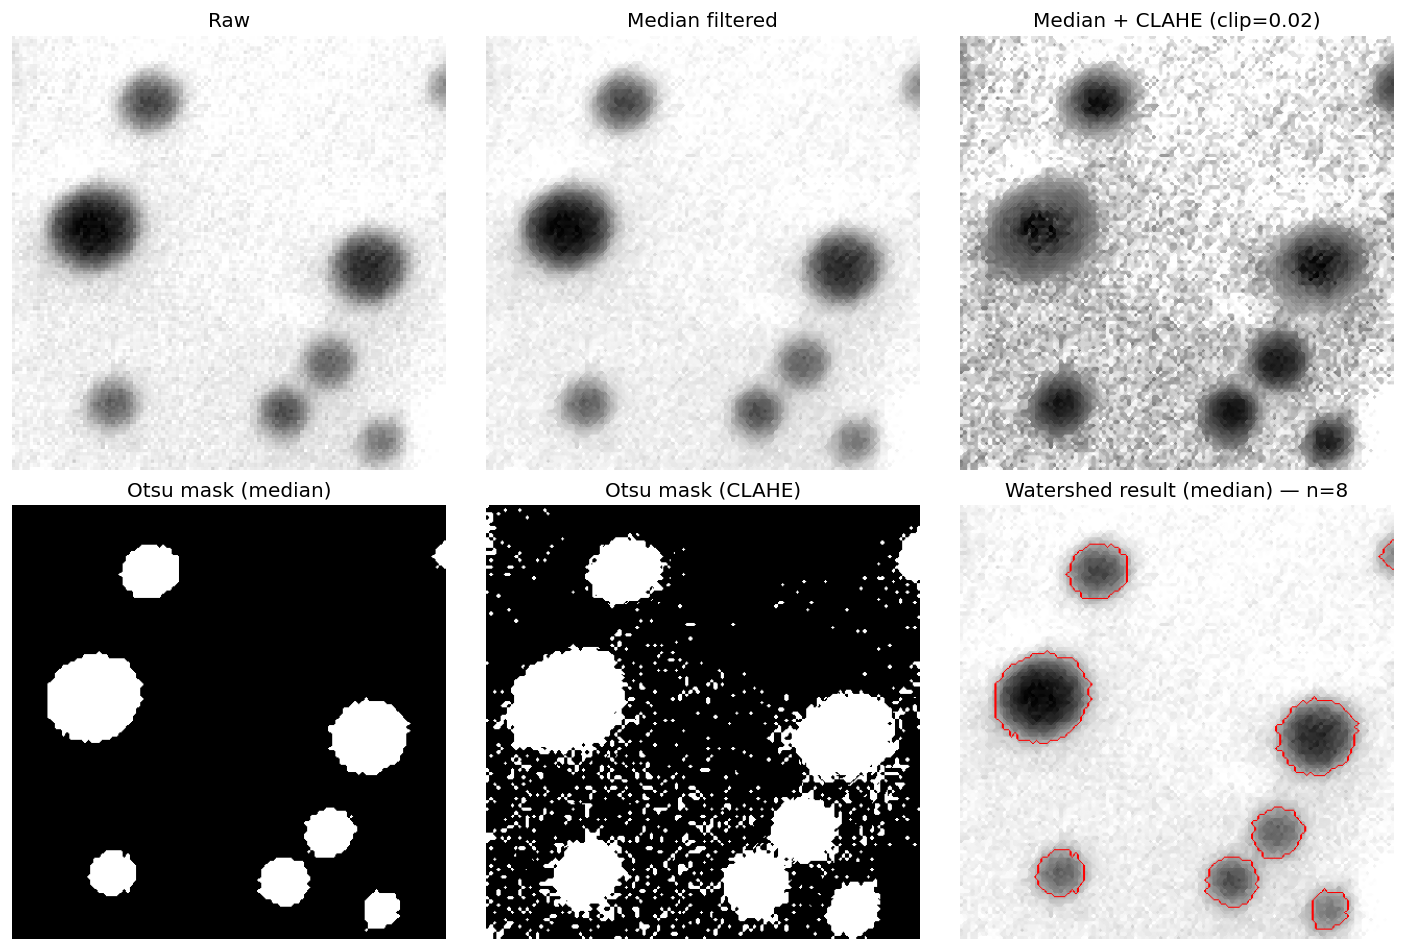

In [69]:
# Import additional libraries
from skimage.segmentation import mark_boundaries

# Select one representative image
rep_path = image_paths[0]
img_raw = load_grayscale_float01(rep_path)

# Median filter (noise reduction)
img_med = denoise_median(img_raw, radius=2)

# CLAHE (contrast enhancement)
clahe_clip = 0.02
img_clahe = apply_clahe(img_med, clip_limit=clahe_clip)

# Otsu thresholds
t_med = threshold_otsu(img_med)
t_clahe = threshold_otsu(img_clahe)

# Correct for dark particles on light background
bin_med = img_med < t_med
bin_clahe = img_clahe < t_clahe

# Full segmentation (watershed)
labels_med = segment_otsu_watershed_dark_particles(img_med)
labels_clahe = segment_otsu_watershed_dark_particles(img_clahe)

# Measurements
snr_raw = compute_snr_mu_over_sigma(img_raw)
snr_med = compute_snr_mu_over_sigma(img_med)

n_med = int(labels_med.max())
n_clahe = int(labels_clahe.max())

print(f"Representative image: {rep_path.name}")
print(f"SNR raw:   {snr_raw:.3f}")
print(f"SNR median:{snr_med:.3f}")
print()
print(f"Otsu threshold (median): {t_med:.4f}  → particles found: {n_med}")
print(f"Otsu threshold (CLAHE {clahe_clip}): {t_clahe:.4f}  → particles found: {n_clahe}")
print()

# Visualization
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0, 0].imshow(img_raw, cmap="gray")
ax[0, 0].set_title("Raw")
ax[0, 0].axis("off")

ax[0, 1].imshow(img_med, cmap="gray")
ax[0, 1].set_title("Median filtered")
ax[0, 1].axis("off")

ax[0, 2].imshow(img_clahe, cmap="gray")
ax[0, 2].set_title(f"Median + CLAHE (clip={clahe_clip})")
ax[0, 2].axis("off")

ax[1, 0].imshow(bin_med, cmap="gray")
ax[1, 0].set_title("Otsu mask (median)")
ax[1, 0].axis("off")

ax[1, 1].imshow(bin_clahe, cmap="gray")
ax[1, 1].set_title("Otsu mask (CLAHE)")
ax[1, 1].axis("off")

# Boundary overlay is easier to read than raw label colors
overlay = mark_boundaries(img_med, labels_med, color=(1, 0, 0))  # red boundaries
ax[1, 2].imshow(overlay)
ax[1, 2].set_title(f"Watershed result (median) — n={n_med}")
ax[1, 2].axis("off")

plt.tight_layout()
plt.show()

As shown in the figures above, adding CLAHE after median filtering actually makes the background look more speckled and less clean when Otsu thresholding is applied. This causes small background artifacts to be picked up as particles, which inflates particle count and reduces segmentation quality.

Because of this, CLAHE will not be used in the final classical pipeline. Instead, median filtering alone will be used moving forward, as it better preserves particle boundaries without introducing additional noise. 

### Part E. Batch Classical Pipeline + CSV export

In [70]:
# Run classical pipeline over subset
all_results = []

for i, path in enumerate(image_paths):
    print(f"Processing {i+1}/{len(image_paths)}: {path.name}")

    # Load
    img = load_grayscale_float01(path)

    # Noise reduction (median)
    img_den = denoise_median(img, radius=3)

    # Compute SNR
    snr_raw = compute_snr_mu_over_sigma(img)
    snr_den = compute_snr_mu_over_sigma(img_den)

    # Segmentation
    labels = segment_otsu_watershed_dark_particles(img_den)

    # Measurements
    df_img = measure_particles(labels, img_den)

    # Add metadata columns
    df_img["image_name"] = path.name
    df_img["snr_raw"] = snr_raw
    df_img["snr_denoised"] = snr_den

    all_results.append(df_img)

# Combine all images
df_all = pd.concat(all_results, ignore_index=True)

print("Total particles detected:", len(df_all))
df_all.head()

Processing 1/100: 11500X00.png
Processing 2/100: 11500X01.png
Processing 3/100: 11500X02.png
Processing 4/100: 11500X03.png
Processing 5/100: 11500X04.png
Processing 6/100: 11500X05.png
Processing 7/100: 11500X06.png
Processing 8/100: 11500X07.png
Processing 9/100: 11500X08.png
Processing 10/100: 11500X09.png
Processing 11/100: 11500X10.png
Processing 12/100: 11500X100.png
Processing 13/100: 11500X101.png
Processing 14/100: 11500X102.png
Processing 15/100: 11500X103.png
Processing 16/100: 11500X104.png
Processing 17/100: 11500X105.png
Processing 18/100: 11500X106.png
Processing 19/100: 11500X107.png
Processing 20/100: 11500X108.png
Processing 21/100: 11500X109.png
Processing 22/100: 11500X11.png
Processing 23/100: 11500X110.png
Processing 24/100: 11500X111.png
Processing 25/100: 11500X112.png
Processing 26/100: 11500X113.png
Processing 27/100: 11500X114.png
Processing 28/100: 11500X115.png
Processing 29/100: 11500X116.png
Processing 30/100: 11500X117.png
Processing 31/100: 11500X118.pn

,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,image_name,snr_raw,snr_denoised
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,11500X00.png,4.852892,4.886471
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,11500X00.png,4.852892,4.886471
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,11500X00.png,4.852892,4.886471
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,11500X00.png,4.852892,4.886471
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,11500X00.png,4.852892,4.886471


In [71]:
# Export combined CSV
csv_path = OUT_DIR / "classical_results.csv"
df_all.to_csv(csv_path, index=False)

print("Saved to:", csv_path.resolve())

Saved to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\classical_results.csv


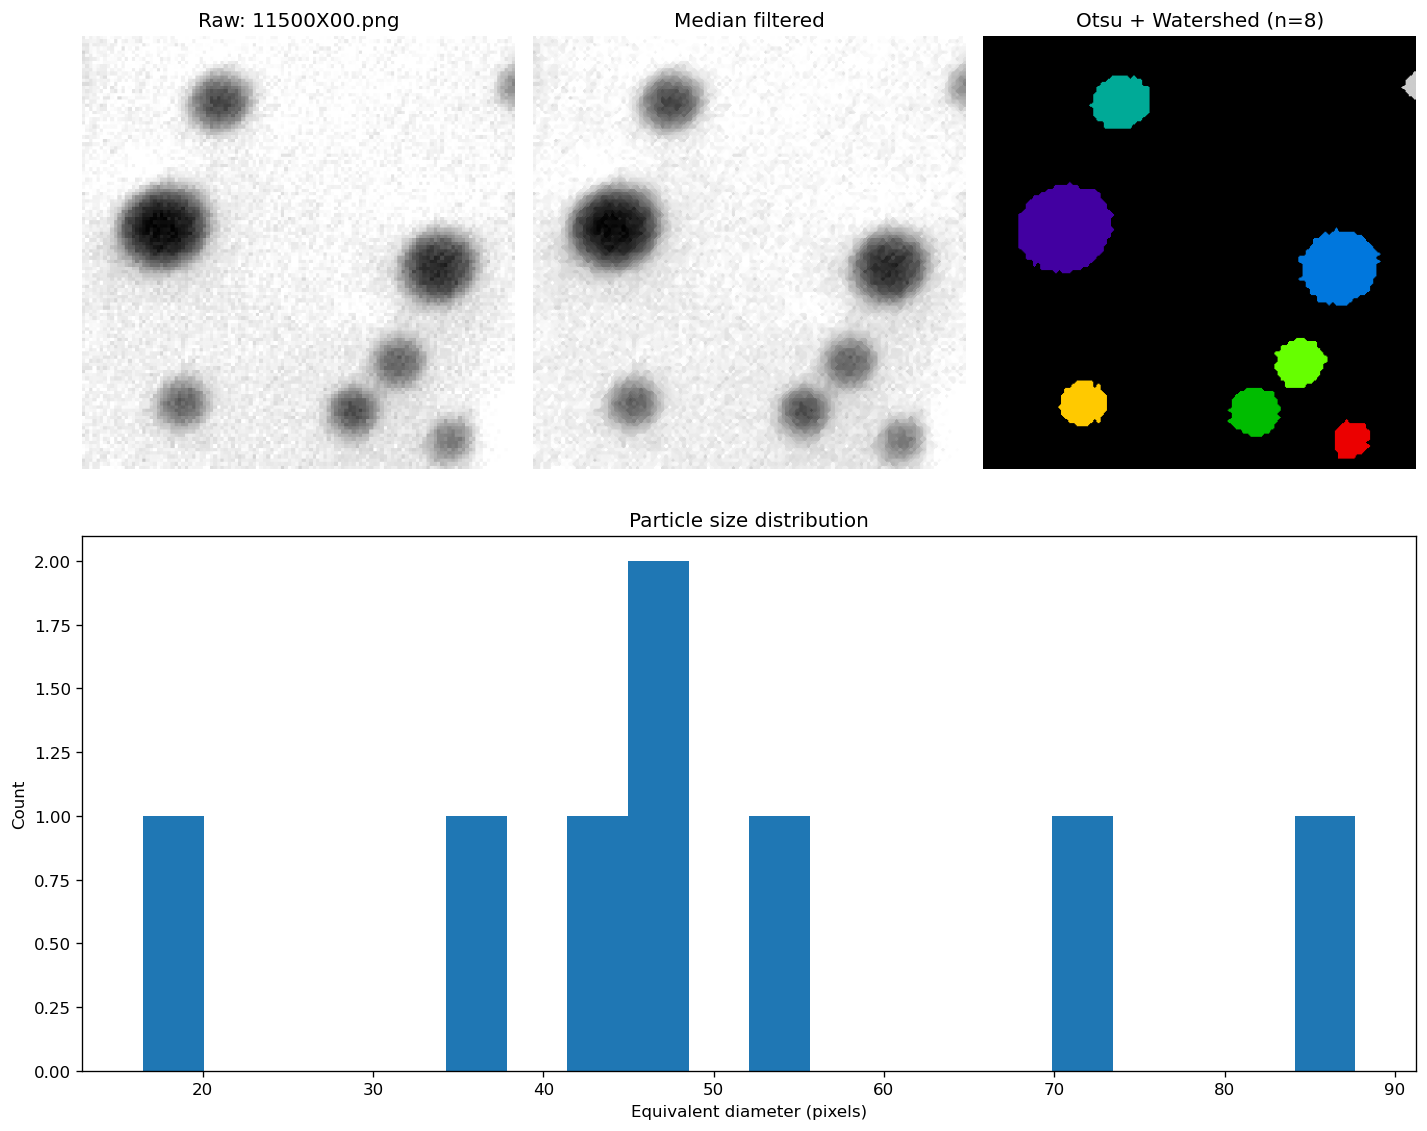

Saved figure to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\task1_figure_noCLAHE.png


In [72]:
# Create & export figure
import matplotlib.pyplot as plt

rep_path = image_paths[0]  # choose any representative image
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)
df_rep = measure_particles(labels, img_den)

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.9])

ax_raw = fig.add_subplot(gs[0, 0])
ax_den = fig.add_subplot(gs[0, 1])
ax_lab = fig.add_subplot(gs[0, 2])
ax_hist = fig.add_subplot(gs[1, :])  # span all columns

# Top row
ax_raw.imshow(img, cmap="gray")
ax_raw.set_title(f"Raw: {rep_path.name}")
ax_raw.axis("off")

ax_den.imshow(img_den, cmap="gray")
ax_den.set_title("Median filtered")
ax_den.axis("off")

ax_lab.imshow(labels, cmap="nipy_spectral")
ax_lab.set_title(f"Otsu + Watershed (n={labels.max()})")
ax_lab.axis("off")

# Bottom histogram
ax_hist.hist(df_rep["equivalent_diameter"], bins=20)
ax_hist.set_title("Particle size distribution")
ax_hist.set_xlabel("Equivalent diameter (pixels)")
ax_hist.set_ylabel("Count")

plt.tight_layout()

fig_path = OUT_DIR / "task1_figure_noCLAHE.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", fig_path.resolve())

### Part E. Task Summary

In [73]:
# One row per image
snr_summary = (
    df_all
    .groupby("image_name")[["snr_raw", "snr_denoised"]]
    .first()
    .reset_index()
)

# Compute delta
snr_summary["delta_snr"] = (
    snr_summary["snr_denoised"] - snr_summary["snr_raw"]
)

snr_summary.head()

,image_name,snr_raw,snr_denoised,delta_snr
0,11500X00.png,4.852892,4.886471,0.033580
1,11500X01.png,4.852892,4.886471,0.033580
2,11500X02.png,4.101608,4.150693,0.049084
3,11500X03.png,4.101608,4.150693,0.049084
4,11500X04.png,5.162778,5.232652,0.069874


In [74]:
mean_delta = snr_summary["delta_snr"].mean()
median_delta = snr_summary["delta_snr"].median()

print("Mean ΔSNR:", mean_delta)
print("Median ΔSNR:", median_delta)

Mean ΔSNR: 0.07549075529636898
Median ΔSNR: 0.06634706772260124


In [75]:
snr_stats = pd.DataFrame({
    "mean_snr_raw": [snr_summary["snr_raw"].mean()],
    "mean_snr_denoised": [snr_summary["snr_denoised"].mean()],
    "mean_delta_snr": [mean_delta],
    "median_delta_snr": [median_delta],
})

snr_stats

snr_stats.to_csv(OUT_DIR / "snr_summary.csv", index=False)
snr_stats_path = OUT_DIR / "snr_summary.csv"

print("Saved summary table to:", snr_stats_path.resolve())

Saved summary table to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\snr_summary.csv


A classical image processing pipeline was developed to segment and characterize particles in the provided dataset. Median filtering was applied to reduce noise while preserving particle boundaries. Although CLAHE contrast enhancement was tested, it increased background speckle and lead to over-segmentation during Otsu thresholding. Therefore, only median filtering was used in the final workflow. 

Particle segmentation was performed using Otsu thresholding followed by watershed refinement to separate touching regions. Morphological and intensity-based features were extracted for each region using regionprops, and results were exported to classical_results.csv. Overall, the classical pipeline successfully identified particles while minimizing false detections from background artifacts.

# Task 2. Machine Learning Approaches

### Part A. Build the Feature Matrix (Hand-Crafted Features)

In [76]:
# Load classical results from Task 1 for feature engineering
df_all = pd.read_csv(OUT_DIR / "classical_results.csv")
print("Task 1 classical rows (regions):", len(df_all))
df_all.head()

# Include circularity
df_all["circularity"] = 4 * np.pi * df_all["area"] / (df_all["perimeter"]**2 + 1e-12)
print("Circularity added to df_all.")

Task 1 classical rows (regions): 1012
Circularity added to df_all.


### Part B. Add Additional Features (≥10 descriptors/region)

#### Part B (i) Helper: compute per-reigon custom features from feature images

In [77]:
# Helper: compute per-region custom features from feature images
import numpy as np
import pandas as pd

from skimage import feature, filters
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
from scipy.ndimage import gaussian_laplace
from skimage.util import img_as_ubyte

def region_custom_features(
    labels: np.ndarray,
    img_den: np.ndarray,
    lbp_radius: int = 2,
    lbp_points: int = 16,   # common: P=8*R
    log_sigma: float = 1.5,
    canny_sigma: float = 1.0,
) -> pd.DataFrame:
    """
    Given labels and an intensity image, compute additional per-region features:
      - Edges: mean Sobel gradient, Canny edge density
      - Texture: LBP (Local Binary Pattern) mean/std
      - Blobs: LoG (Laplacian of Gaussian) response mean/std/max
    Returns a DataFrame with one row per labeled region.
    """
    # Feature images (computed once per image)
    sob = filters.sobel(img_den)  # Sobel edge magnitude image
    can = feature.canny(img_den, sigma=canny_sigma).astype(np.uint8)  # binary edges

    # LBP texture codes (uniform recommended; produces integer-ish codes)
    img_uint8 = img_as_ubyte(img_den)
    lbp = local_binary_pattern(img_uint8, P=lbp_points, R=lbp_radius, method="uniform")

    # LoG response image (blob-like structures give stronger response)
    log_resp = -gaussian_laplace(img_den, sigma=log_sigma)

    rows = []
    for r in regionprops(labels, intensity_image=img_den):
        mask = (labels == r.label)

        # Edge features
        sobel_mean = float(sob[mask].mean())
        canny_edge_density = float(can[mask].mean())  # fraction of pixels that are edges

        # Texture (LBP) features
        lbp_vals = lbp[mask]
        lbp_mean = float(lbp_vals.mean())
        lbp_std = float(lbp_vals.std())

        # Blob (LoG) features
        log_vals = log_resp[mask]
        log_mean = float(log_vals.mean())
        log_std = float(log_vals.std())
        log_max = float(log_vals.max())

        rows.append({
            "label": r.label,
            "sobel_mean": sobel_mean,
            "canny_edge_density": canny_edge_density,
            "lbp_mean": lbp_mean,
            "lbp_std": lbp_std,
            "log_mean": log_mean,
            "log_std": log_std,
            "log_max": log_max,
        })

    return pd.DataFrame(rows)

In [78]:
# One-image sanity check
rep_path = image_paths[0]

img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=3)
labels = segment_otsu_watershed_dark_particles(img_den)

df_morph = measure_particles(labels, img_den)    # morphology + intensity
df_extra = region_custom_features(labels, img_den)

df_one = df_morph.merge(df_extra, on="label", how="left")
df_one["image_name"] = rep_path.name

# circularity derived feature
df_one["circularity"] = 4 * np.pi * df_one["area"] / (df_one["perimeter"]**2 + 1e-12)

print("Sanity check df_one shape:", df_one.shape)
df_one.head()

Sanity check df_one shape: (8, 17)


,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,sobel_mean,canny_edge_density,lbp_mean,lbp_std,log_mean,log_std,log_max,image_name,circularity
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,0.033218,0.156332,9.873021,2.877278,-0.001608,0.005237,0.015383,11500X00.png,0.809390
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,0.032047,0.171552,10.109322,3.138377,-0.001805,0.005359,0.020382,11500X00.png,0.804094
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,0.030597,0.178988,9.906615,2.778292,-0.002349,0.004988,0.012514,11500X00.png,0.855099
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,0.031863,0.203632,10.070446,2.823264,-0.002668,0.005085,0.023357,11500X00.png,0.812074
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,0.025679,0.166192,10.705748,3.334925,-0.002364,0.005036,0.014172,11500X00.png,0.826556


In [79]:
# Build full feature table across subset: df_feat
all_feat = []

for i, path in enumerate(image_paths, start=1):
    print(f"Features {i}/{len(image_paths)}: {path.name}")

    img = load_grayscale_float01(path)
    img_den = denoise_median(img, radius=3)
    labels = segment_otsu_watershed_dark_particles(img_den)

    df_morph = measure_particles(labels, img_den)
    df_extra = region_custom_features(labels, img_den)

    df_img = df_morph.merge(df_extra, on="label", how="left")
    df_img["image_name"] = path.name

    # derived morphology feature
    df_img["circularity"] = 4 * np.pi * df_img["area"] / (df_img["perimeter"]**2 + 1e-12)

    all_feat.append(df_img)

df_feat = pd.concat(all_feat, ignore_index=True)
print("Total regions in df_feat:", len(df_feat))
df_feat.head()

Features 1/100: 11500X00.png
Features 2/100: 11500X01.png
Features 3/100: 11500X02.png
Features 4/100: 11500X03.png
Features 5/100: 11500X04.png
Features 6/100: 11500X05.png
Features 7/100: 11500X06.png
Features 8/100: 11500X07.png
Features 9/100: 11500X08.png
Features 10/100: 11500X09.png
Features 11/100: 11500X10.png
Features 12/100: 11500X100.png
Features 13/100: 11500X101.png
Features 14/100: 11500X102.png
Features 15/100: 11500X103.png
Features 16/100: 11500X104.png
Features 17/100: 11500X105.png
Features 18/100: 11500X106.png
Features 19/100: 11500X107.png
Features 20/100: 11500X108.png
Features 21/100: 11500X109.png
Features 22/100: 11500X11.png
Features 23/100: 11500X110.png
Features 24/100: 11500X111.png
Features 25/100: 11500X112.png
Features 26/100: 11500X113.png
Features 27/100: 11500X114.png
Features 28/100: 11500X115.png
Features 29/100: 11500X116.png
Features 30/100: 11500X117.png
Features 31/100: 11500X118.png
Features 32/100: 11500X119.png
Features 33/100: 11500X12.png

,label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,intensity_std,sobel_mean,canny_edge_density,lbp_mean,lbp_std,log_mean,log_std,log_max,image_name,circularity
0,1,6064.0,306.835570,87.868792,0.464155,0.967454,0.313769,0.196861,0.033218,0.156332,9.873021,2.877278,-0.001608,0.005237,0.015383,11500X00.png,0.809390
1,2,4162.0,255.036580,72.795762,0.349122,0.957002,0.391954,0.151467,0.032047,0.171552,10.109322,3.138377,-0.001805,0.005359,0.020382,11500X00.png,0.804094
2,3,2313.0,184.367532,54.267882,0.444351,0.966973,0.469393,0.114801,0.030597,0.178988,9.906615,2.778292,-0.002349,0.004988,0.012514,11500X00.png,0.855099
3,4,1817.0,167.681241,48.098610,0.144159,0.951309,0.495969,0.108640,0.031863,0.203632,10.070446,2.823264,-0.002668,0.005085,0.023357,11500X00.png,0.812074
4,5,1757.0,163.438600,47.297800,0.412066,0.960109,0.528472,0.081952,0.025679,0.166192,10.705748,3.334925,-0.002364,0.005036,0.014172,11500X00.png,0.826556


In [80]:
# Sanity checks
print("Images in subset:", df_feat["image_name"].nunique())
print("Regions per image (summary):")
display(df_feat.groupby("image_name")["label"].count().describe())

Images in subset: 100
Regions per image (summary):


count    100.000000
mean      10.120000
std        2.095112
min        5.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       14.000000
Name: label, dtype: float64

In [81]:
# Define/choose feature columns
feature_cols = [
    # morphology/intensity
    "area", "perimeter", "equivalent_diameter", "eccentricity", "solidity",
    "mean_intensity", "intensity_std", "circularity",
    # edges
    "sobel_mean", "canny_edge_density",
    # texture
    "lbp_mean", "lbp_std",
    # blobs
    "log_mean", "log_std", "log_max",
]

# Confirmation
missing = [c for c in feature_cols if c not in df_feat.columns]
print("Missing columns:", missing)

X = df_feat[feature_cols].copy()
print("X shape:", X.shape)

Missing columns: []
X shape: (1012, 15)


### Part C. Feature Scaling + Feature Selection

In [82]:
# Clean feature table and define supervised target y
from sklearn.preprocessing import StandardScaler

df_feat_clean = df_feat.replace([np.inf, -np.inf], np.nan).fillna(0)

X = df_feat_clean[feature_cols].copy()

# Supervised target: small vs large by median diameter (proxy label)
diam_thresh = df_feat_clean["equivalent_diameter"].median()
y = (df_feat_clean["equivalent_diameter"] > diam_thresh).astype(int)

print("Diameter threshold (median):", diam_thresh)
print("Class counts:\n", y.value_counts())

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Diameter threshold (median): 45.723728330650566
Class counts:
 equivalent_diameter
0    511
1    501
Name: count, dtype: int64


In [83]:
# Random Forest feature importance
from sklearn.ensemble import RandomForestClassifier

rf_imp = RandomForestClassifier(n_estimators=300, random_state=0)
rf_imp.fit(X_scaled, y)

feat_importance = (
    pd.DataFrame({"feature": feature_cols, "importance": rf_imp.feature_importances_})
    .sort_values("importance", ascending=False)
)
display(feat_importance)

,feature,importance
2,equivalent_diameter,0.306152
0,area,0.305643
1,perimeter,0.197960
6,intensity_std,0.065285
12,log_mean,0.031049
14,log_max,0.026436
5,mean_intensity,0.023739
3,eccentricity,0.011411
10,lbp_mean,0.011323
7,circularity,0.006649


In [84]:
# Correlation filter & select top 7 features
corr = pd.DataFrame(X_scaled, columns=feature_cols).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr = [col for col in upper.columns if any(upper[col] > 0.90)]
print("Highly correlated (>0.90):", high_corr)

selected_features = []
for feat in feat_importance["feature"]:
    if feat not in high_corr:
        selected_features.append(feat)
    if len(selected_features) == 7:
        break

print("Selected features:", selected_features)

X_final = df_feat_clean[selected_features].copy()
X_final_scaled = StandardScaler().fit_transform(X_final)

Highly correlated (>0.90): ['perimeter', 'equivalent_diameter']
Selected features: ['area', 'intensity_std', 'log_mean', 'log_max', 'mean_intensity', 'eccentricity', 'lbp_mean']


### Part D. Supervised Learning (SVM + Random Forest)

SVM report:
               precision    recall  f1-score   support

           0      0.955     0.968     0.961       154
           1      0.966     0.953     0.960       150

    accuracy                          0.961       304
   macro avg      0.961     0.960     0.961       304
weighted avg      0.961     0.961     0.961       304



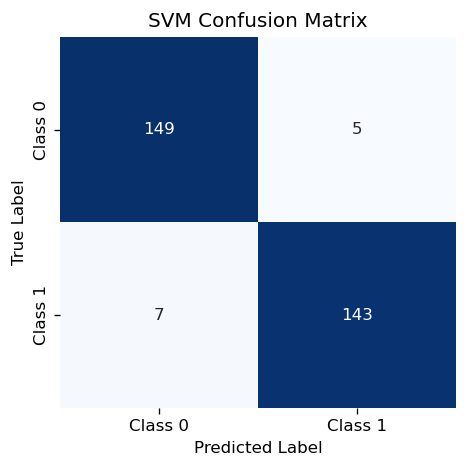


RF report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       154
           1      1.000     1.000     1.000       150

    accuracy                          1.000       304
   macro avg      1.000     1.000     1.000       304
weighted avg      1.000     1.000     1.000       304



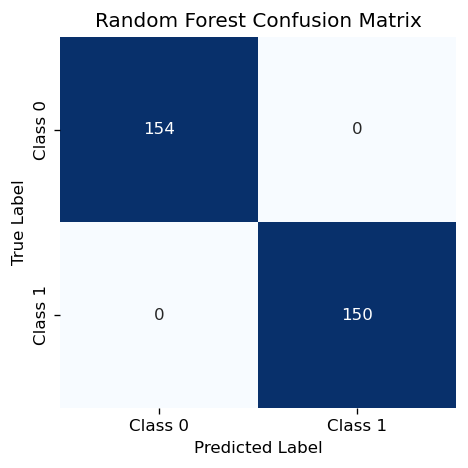

In [85]:
# Train & test (SVM/RF)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_final_scaled, y, test_size=0.30, random_state=0, stratify=y
)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm_norm,
        annot=cm,
        fmt="d",
        cmap="Blues",
        xticklabels=["Class 0", "Class 1"],
        yticklabels=["Class 0", "Class 1"],
        cbar=False
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
# SVM
svm = SVC(kernel="rbf", random_state=0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM report:\n", classification_report(y_test, y_pred_svm, digits=3))
plot_confusion(y_test, y_pred_svm, "SVM Confusion Matrix")

# RF
rf = RandomForestClassifier(n_estimators=300, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRF report:\n", classification_report(y_test, y_pred_rf, digits=3))
plot_confusion(y_test, y_pred_rf,  "Random Forest Confusion Matrix")

### Part E. Unsupervised Learning (k-Means + PCA + Silhouette)

In [86]:
# PCA + k-means + silhouette sweep
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the same selected features for consistency
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_final_scaled)

sil_scores = []
k_list = list(range(3,9))

for k in k_list:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels_k = km.fit_predict(X_final_scaled)
    sil = silhouette_score(X_final_scaled, labels_k)
    sil_scores.append(sil)

sil_table = pd.DataFrame({"k": k_list, "silhouette": sil_scores})
display(sil_table)

,k,silhouette
0,3,0.258815
1,4,0.226242
2,5,0.233645
3,6,0.232933
4,7,0.209175
5,8,0.220784


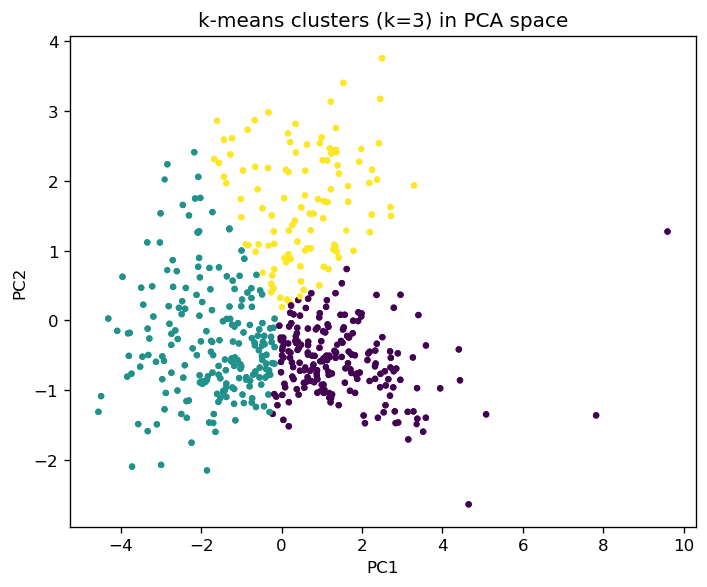

In [87]:
# PCA scatter for "best" k
k_chosen = 3
km = KMeans(n_clusters=k_chosen, random_state=0, n_init=10)
clusters = km.fit_predict(X_final_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8, c=clusters)
plt.title(f"k-means clusters (k={k_chosen}) in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

### Part F. Export Results

In [88]:
# Collect supervised metrics
from sklearn.metrics import accuracy_score, f1_score

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("SVM Accuracy:", svm_acc)
print("SVM F1:", svm_f1)
print("RF Accuracy:", rf_acc)
print("RF F1:", rf_f1)

SVM Accuracy: 0.9605263157894737
SVM F1: 0.959731543624161
RF Accuracy: 1.0
RF F1: 1.0


In [89]:
# Create & export results summary table
svm_f1 = f1_score(y_test, y_pred_svm)
rf_f1  = f1_score(y_test, y_pred_rf)

best_k = sil_table.loc[sil_table["silhouette"].idxmax(), "k"]
best_sil = sil_table["silhouette"].max()

ml_summary = pd.DataFrame([{
    "n_regions_total": len(df_feat_clean),
    "n_images": df_feat_clean["image_name"].nunique(),
    "n_features_total": len(feature_cols),
    "n_features_selected": len(selected_features),
    "supervised_target": "small_vs_large_by_median_equiv_diameter",
    "diameter_threshold": float(diam_thresh),
    "svm_f1": float(svm_f1),
    "rf_f1": float(rf_f1),
    "best_k_by_silhouette": int(best_k),
    "best_silhouette": float(best_sil),
}])

display(ml_summary)

out_path = OUT_DIR / "ml_results.csv"
ml_summary.to_csv(out_path, index=False)
print("Saved:", out_path)

,n_regions_total,n_images,n_features_total,n_features_selected,supervised_target,diameter_threshold,svm_f1,rf_f1,best_k_by_silhouette,best_silhouette
0,1012,100,15,7,small_vs_large_by_median_equiv_diameter,45.723728,0.959732,1.0,3,0.258815


Saved: assignment_04_output\ml_results.csv


### Part G. Task Summary

Hand-crafted morphological, intensity, edge, and texture features were computed for 1,012 segmented regions across 100 images. After feature scaling and correlation filtering, the seven most informative features were selected using Random Forest importance ranking.

For supervised learning, regions were labeled into two classes (small vs. large) based on the median equivalent diameter (45.72). Both SVM and Random Forest classifiers were trained using a stratified train/test split. The SVM achieved an F1-score of 0.96, and the Random Forest achieved an F1-score of 1.00, indicating strong separability between the two classes.

Unsupervised learning using k-means clustering identified k = 3 as the optimal number of clusters (silhouette score ≈ 0.26). PCA visualization showed partial separation among clusters, suggesting moderate but meaningful structure in the feature space.

## Task 3. Deep Learning and Final Comparison

### Part A. Prepare Pixel-Level Annotations and Implement Data Augmentation for Training

In [90]:
# Define directories
from pathlib import Path

RAW_DIR = Path("raw_data")
MASK_DIR = Path("raw_masks")
MASK_DIR.mkdir(exist_ok=True)

OUT_DIR = Path("assignment_04_output")
OUT_DIR.mkdir(exist_ok=True)

print("RAW_DIR:", RAW_DIR.resolve())
print("MASK_DIR:", MASK_DIR.resolve())

RAW_DIR: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\raw_data
MASK_DIR: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\raw_masks


In [91]:
# Collect images
exts = ["*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"]
image_paths = []
for ext in exts:
    image_paths += sorted(RAW_DIR.glob(ext))

print("Images found:", len(image_paths))
print("Example:", image_paths[0].name if image_paths else "None")

def mask_path_for_image(img_path: Path) -> Path:
    return MASK_DIR / f"{img_path.stem}_mask.png"

# Check how many masks already exist
paired = [(p, mask_path_for_image(p)) for p in image_paths]
n_masks = sum(m.exists() for _, m in paired)

print("Masks found:", n_masks, "out of", len(image_paths))

Images found: 201
Example: 11500X00.png
Masks found: 20 out of 201


In [92]:
N_ANN = 40 # 15-20 required :contentReference[oaicite:2]{index=2}

# Prefer images that already have masks; otherwise take first N
paired_with_masks = [(img, m) for img, m in paired if m.exists()]
paired_no_masks = [(img, m) for img, m in paired if not m.exists()]

if len(paired_with_masks) >= 15:
    selected = paired_with_masks[:N_ANN]
    print("Using existing masks:", len(selected), "images")
else: 
    selected = paired[:N_ANN]
    print("Not enough existing masks. Will need to create masks for:", len(selected), "images")

selected[:3]

Using existing masks: 20 images


[(WindowsPath('raw_data/11500X00.png'),
  WindowsPath('raw_masks/11500X00_mask.png')),
 (WindowsPath('raw_data/11500X01.png'),
  WindowsPath('raw_masks/11500X01_mask.png')),
 (WindowsPath('raw_data/11500X02.png'),
  WindowsPath('raw_masks/11500X02_mask.png'))]

In [93]:
# Create masks
import numpy as np
from skimage.io import imread, imsave
from skimage.color import rgb2gray

# Re-using Task 1 helpers
# load_grayscale_float01, denoise_median, segment_otsu_watershed_dark_particles

for img_path, m_path in selected: 
    if m_path.exists():
        continue

    img = load_grayscale_float01(img_path)
    img_den = denoise_median(img, radius=2)
    labels = segment_otsu_watershed_dark_particles(img_den)

    # Binary mask: particles = labels > 0
    mask = (labels > 0).astype(np.uint8)

    imsave(m_path, mask * 255)
    print("Wrote mask:", m_path.name)

Image: (416, 416) float64 0.0 1.0
Mask: (416, 416) uint8 [0 1]


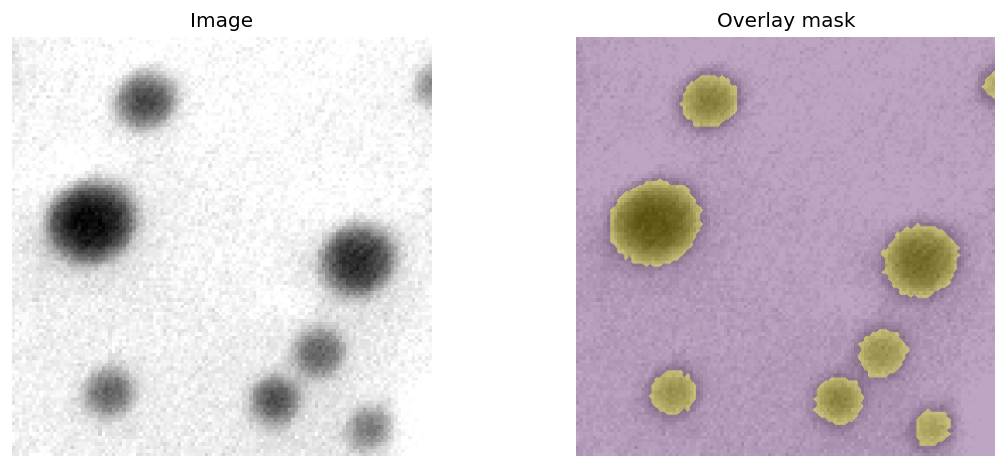

In [94]:
# Sanity check
import matplotlib.pyplot as plt
from skimage.io import imread

img_path, m_path = selected[0]
img = load_grayscale_float01(img_path)
mask = imread(m_path)

# if saved as 0/255, convert to 0/1
mask01 = (mask > 0).astype(np.uint8)

print("Image:", img.shape, img.dtype, img.min(), img.max())
print("Mask:", mask01.shape, mask01.dtype, np.unique(mask01))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img,cmap="gray")
plt.imshow(mask01,alpha=0.35)
plt.title("Overlay mask")
plt.axis("off")
plt.tight_layout()
plt.show()

### Part B. CNN Classification

In [95]:
# Resize for convenience
# Import & confirm libraries
import tensorflow as tf
import numpy as np
from pathlib import Path

IMG_SIZE = 416
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

# selected should already be a list of (img_path, mask_path)
print("Selected pairs:", len(selected))
print(selected[0][0].name, selected[0][1].name)

Selected pairs: 20
11500X00.png 11500X00_mask.png


In [96]:
# TF loader for one pair
def _read_png(path):
    bytes_ = tf.io.read_file(path)
    img = tf.image.decode_png(bytes_, channels=1)
    return img

def load_pair_tf(img_path, mask_path):
    img = _read_png(img_path)
    mask = _read_png(mask_path)

    # Resize if needed
    if IMG_SIZE is not None:
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
        mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")

    # Normalize image to [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    # Binarize mask to {0,1}
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask

In [98]:
# Build train/val split
from sklearn.model_selection import train_test_split

pairs = [(str(i), str(m)) for i, m in selected]

train_pairs, val_pairs = train_test_split(
    pairs,
    test_size=0.4,
    random_state=0
)

print("Train:", len(train_pairs), "Val:", len(val_pairs))

Train: 12 Val: 8


In [99]:
# Augmentation function (>/= 5 variants)
def augment_pair(img, mask):
    # 1) Random flips
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # 2) Random 90-degree rotations
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # 3) Brightness/contrast (image only)
    img = tf.image.random_brightness(img, max_delta=0.88)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # Clip image to valid range
    img = tf.clip_by_value(img, 0.0, 1.0)

    # 4) Small translation (both) 
    dx = tf.random.uniform((), -12, 13, dtype=tf.int32)
    dy = tf.random.uniform((), -12, 13, dtype=tf.int32)
    img = tf.roll(img, shift=[dy, dx], axis=[0, 1])
    mask = tf.roll(mask, shift=[dy, dx], axis=[0, 1])

    return img, mask    

In [100]:
# Create tf.data.Dataset
def make_dataset(pairs, training: bool):
    img_paths = [p[0] for p in pairs]
    mask_paths = [p[1] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda i, m: load_pair_tf(i, m), num_parallel_calls=AUTOTUNE)

    if training: 
        ds = ds.shuffle(buffer_size=len(pairs), reshuffle_each_iteration=True)
        ds = ds.map(augment_pair, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, training=True)
val_ds = make_dataset(val_pairs, training=False)

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 416, 416, 1), dtype=tf.float32, name=None))>)

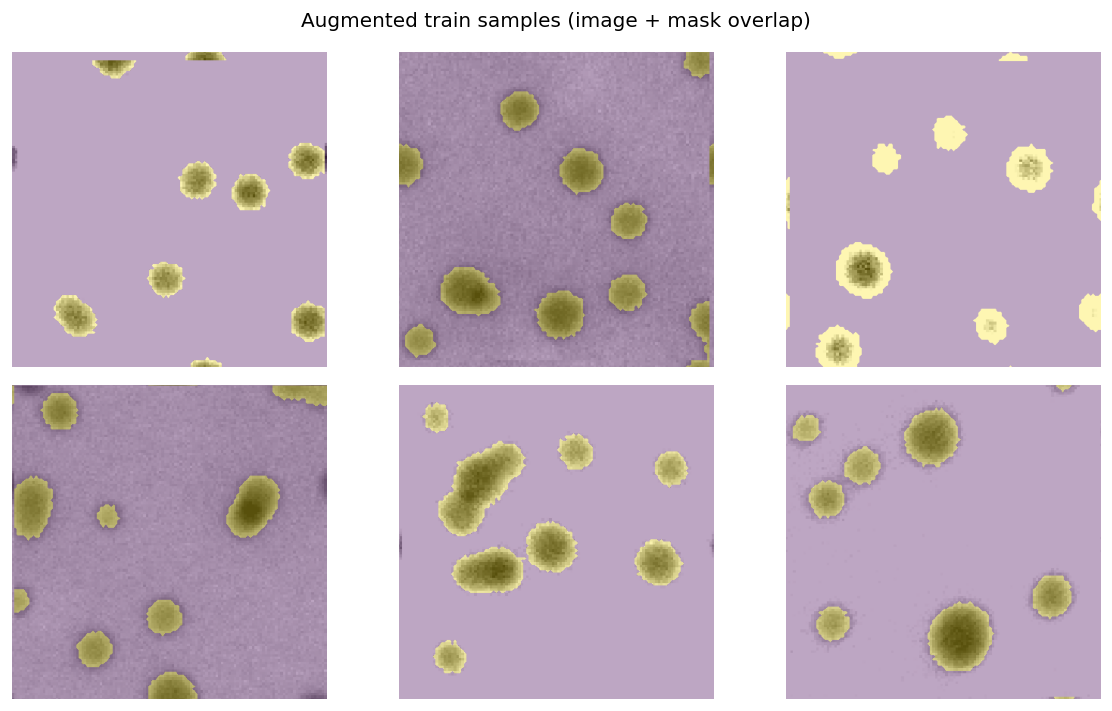

In [101]:
# Visual sanity check
import matplotlib.pyplot as plt

for imgs, masks in train_ds.take(1):
    imgs = imgs.numpy()
    masks = masks.numpy()

plt.figure(figsize=(10,6))
for i in range(min(6, imgs.shape[0])):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i,...,0], cmap="gray")
    plt.imshow(masks[i,...,0], alpha=0.35)
    plt.axis("off")
plt.suptitle("Augmented train samples (image + mask overlap)")
plt.tight_layout()
plt.show()

In [102]:
# CNN (Image-level classification)
# Build image-level labels

image_group = df_feat.groupby("image_name")["equivalent_diameter"].median()

global_median = df_feat["equivalent_diameter"].median()

image_labels = (image_group > global_median).astype(int)

image_labels.head()

image_name
11500X00.png    1
11500X01.png    1
11500X02.png    1
11500X03.png    1
11500X04.png    1
Name: equivalent_diameter, dtype: int64

In [103]:
def get_image_label(img_path):
    return int(image_labels[img_path.name])

# Add labels to train/val pairs
train_pairs_labeled = [(i, m, get_image_label(Path(i))) for i, m in train_pairs]
val_pairs_labeled = [(i, m, get_image_label(Path(i))) for i, m in val_pairs]

print("Example:", train_pairs_labeled[0])

Example: ('raw_data\\11500X04.png', 'raw_masks\\11500X04_mask.png', 1)


In [104]:
# Create CNN Dataset
def make_cnn_dataset(pairs, training):
    img_paths = [p[0] for p in pairs]
    labels = [p[2] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))

    def _load(img_path, label):
        img = _read_png(img_path)
        img = tf.cast(img, tf.float32) / 255.0
        if IMG_SIZE is not None:
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(len(pairs)).map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_cnn = make_cnn_dataset(train_pairs_labeled, True)
val_cnn = make_cnn_dataset(val_pairs_labeled, False)

In [106]:
# Define Simple CNN
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = build_simple_cnn()
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)            │ (None, 416, 416, 16)  │          160 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_9               │ (None, 208, 208, 16)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_22 (Conv2D)            │ (None, 208, 208, 32)  │        4,640 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_10              │ (None, 104, 104, 32)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_23 (Conv2D)            │ (None, 104, 104, 64)  │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_11              │ (None, 52, 52, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_2 (Flatten)           │ (None, 173056)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_4 (Dense)               │ (None, 64)            │   11,075,648 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_5 (Dense)               │ (None, 1)             │           65 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 11,099,009 (42.34 MB)

 Trainable params: 11,099,009 (42.34 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Compile & Train
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = cnn_model.fit(
    train_cnn,
    validation_data=val_cnn,
    epochs=30
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.2500 - loss: 5.1665 - val_accuracy: 0.6250 - val_loss: 5.7883
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7500 - loss: 3.0402 - val_accuracy: 0.6250 - val_loss: 0.6543
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7500 - loss: 0.5688 - val_accuracy: 0.3750 - val_loss: 0.6932
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2500 - loss: 0.6933 - val_accuracy: 0.3750 - val_loss: 0.6932
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4167 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6931
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7500 - loss: 0.6930 - val_accuracy: 0.6250 - val_loss: 0.6930
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7500 - loss: 0.6927 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7500 - loss: 0.6925 - val_accuracy: 0.6250 - val_loss:

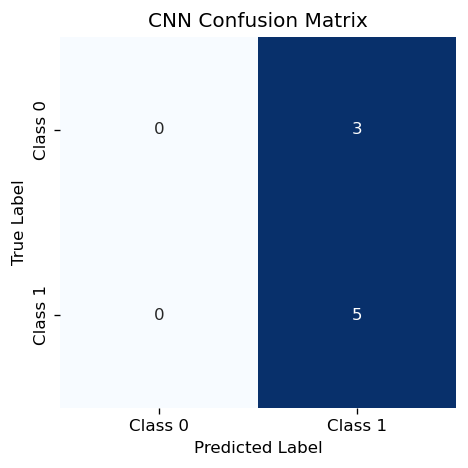


Classification report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.625     1.000     0.769         5

    accuracy                          0.625         8
   macro avg      0.312     0.500     0.385         8
weighted avg      0.391     0.625     0.481         8

F1: 0.7692307692307693


C:\Users\elise\miniforge3\envs\matsci465\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elise\miniforge3\envs\matsci465\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elise\miniforge3\envs\matsci465\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [108]:
# Evaluate CNN
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# get predictions on val set
y_true = []
y_pred = []

for x_batch, y_batch in val_cnn: 
    preds = cnn_model.predict(x_batch, verbose=0).ravel()
    y_true.extend(y_batch.numpy().astype(int).tolist())
    y_pred.extend((preds >= 0.5).astype(int).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

plot_confusion(y_true, y_pred, "CNN Confusion Matrix")

print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3))
print("F1:", f1_score(y_true, y_pred))

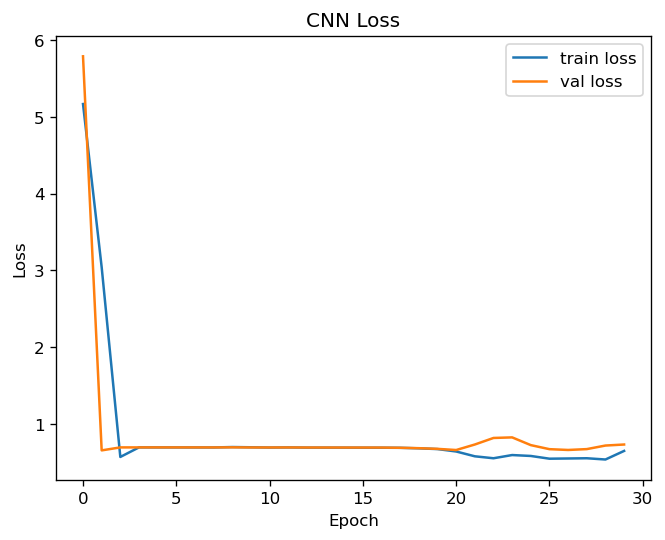

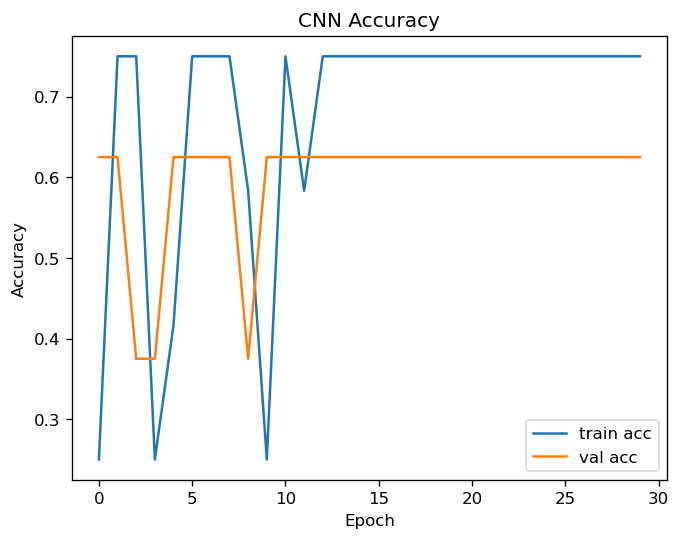

In [109]:
# Plot training curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Part C. U-Net Segmentation

In [119]:
# Build a small U-Net
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    y = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D()(c3)

    # Bottlebeck
    b = conv_block(p3, 128)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 64)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 32)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return models.Model(inputs, outputs)

unet_model = build_unet()
unet_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer_5      │ (None, 416, 416, │         0 │ -                │
│ (InputLayer)       │ 1)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_39 (Conv2D) │ (None, 416, 416, │       160 │ input_layer_5[0… │
│                    │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling2d_15   │ (None, 208, 208, │         0 │ conv2d_39[0][0]  │
│ (MaxPooling2D)     │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_41 (Conv2D) │ (None, 208, 208, │     4,640 │ max_pooling2d_1… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling2d_16   │ (None, 104, 104, │         0 │ conv2d_41[0][0]  │
│ (MaxPooling2D)     │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_43 (Conv2D) │ (None, 104, 104, │    18,496 │ max_pooling2d_1… │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling2d_17   │ (None, 52, 52,   │         0 │ conv2d_43[0][0]  │
│ (MaxPooling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_45 (Conv2D) │ (None, 52, 52,   │    73,856 │ max_pooling2d_1… │
│                    │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ up_sampling2d_6    │ (None, 104, 104, │         0 │ conv2d_45[0][0]  │
│ (UpSampling2D)     │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ concatenate_6      │ (None, 104, 104, │         0 │ up_sampling2d_6… │
│ (Concatenate)      │ 192)             │           │ conv2d_43[0][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_47 (Conv2D) │ (None, 104, 104, │   110,656 │ concatenate_6[0… │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ up_sampling2d_7    │ (None, 208, 208, │         0 │ conv2d_47[0][0]  │
│ (UpSampling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ concatenate_7      │ (None, 208, 208, │         0 │ up_sampling2d_7… │
│ (Concatenate)      │ 96)              │           │ conv2d_41[0][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_49 (Conv2D) │ (None, 208, 208, │    27,680 │ concatenate_7[0… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ up_sampling2d_8    │ (None, 416, 416, │         0 │ conv2d_49[0][0]  │
│ (UpSampling2D)     │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ concatenate_8      │ (None, 416, 416, │         0 │ up_sampling2d_8… │
│ (Concatenate)      │ 48)              │           │ conv2d_39[0][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_51 (Conv2D) │ (None, 416, 416, │     6,928 │ concatenate_8[0… │
│                    │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_53 (Conv2D) │ (None, 416, 416, │        17 │ conv

 Total params: 242,433 (947.00 KB)

 Trainable params: 242,433 (947.00 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# Define Dice + IoU metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.2, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return (2. * intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.2, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    union = total - intersection

    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

A threshold of 0.2 was selected based on validation Dice performance. Higher thresholds (e.g., 0.5) resulted in under-segmentation due to conservative probability outputs.

In [121]:
# Compile
unet_model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_metric]
)

In [122]:
# Train (add early stopping to improve predictions)
cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history_unet = unet_model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=30, callbacks=[cb]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - dice_coef: 0.1947 - iou_metric: 0.1079 - loss: 1.5375 - val_dice_coef: 0.2097 - val_iou_metric: 0.1172 - val_loss: 1.4599
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - dice_coef: 0.1884 - iou_metric: 0.1041 - loss: 1.4719 - val_dice_coef: 0.2097 - val_iou_metric: 0.1172 - val_loss: 1.3454
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - dice_coef: 0.1913 - iou_metric: 0.1058 - loss: 1.3403 - val_dice_coef: 0.2687 - val_iou_metric: 0.1552 - val_loss: 1.1389
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - dice_coef: 0.2399 - iou_metric: 0.1368 - loss: 1.2150 - val_dice_coef: 0.1286 - val_iou_metric: 0.0687 - val_loss: 1.1847
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - dice_coef: 0.2635 - iou_metric: 0.1596 - loss: 1.2229 - val_dice_coef: 0.0867 - val_iou_metric: 0.0453 - val_loss: 1.2491
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - dice_coef: 0.2481 - iou_metric: 0.1417 - loss: 1.2070 - val_dice_coef: 0.1940 - v

In [123]:
# Evaluate
results = unet_model.evaluate(val_ds)
print("Validation results:", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - dice_coef: 0.6546 - iou_metric: 0.4865 - loss: 0.9889
Validation results: [0.9888894557952881, 0.6545659899711609, 0.48650920391082764]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


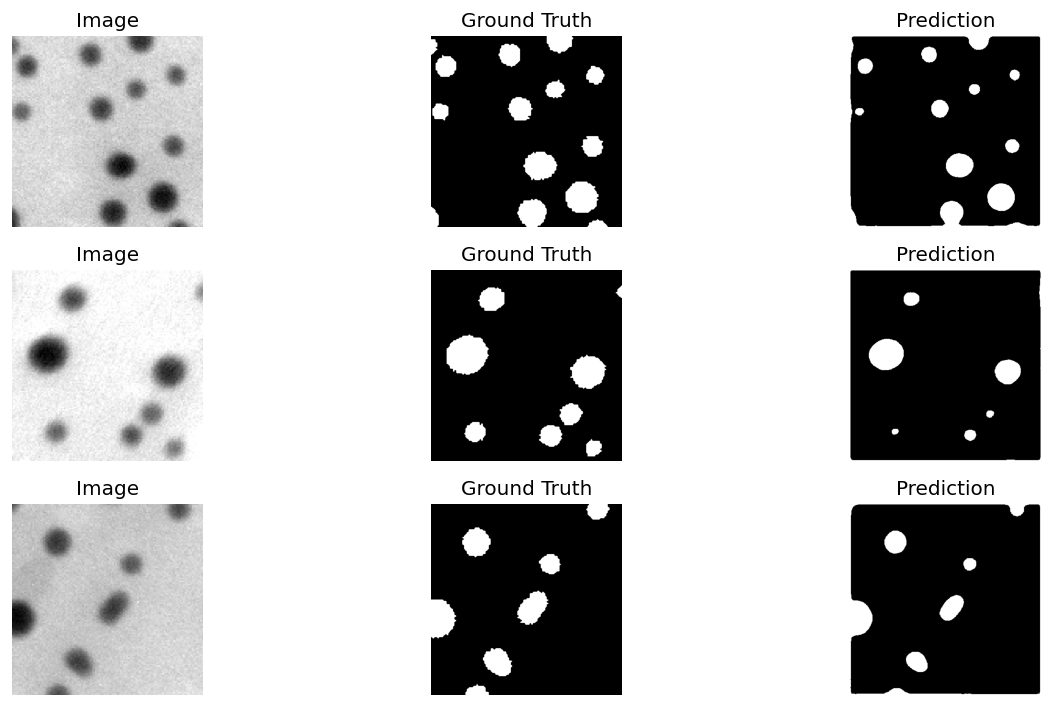

In [124]:
# Visualize predictions
import matplotlib.pyplot as plt

for imgs, masks in val_ds.take(1):
    preds = unet_model.predict(imgs)
    preds_bin = (preds > 0.2).astype(float)

plt.figure(figsize=(12,6))
for i in range(min(3, imgs.shape[0])):
    plt.subplot(3,3,3*i+1)
    plt.imshow(imgs[i,...,0], cmap="gray")
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i,...,0], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds_bin[i,...,0], cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [125]:
# Save current model and metrics
unet_model.save(OUT_DIR / "unet_model.keras")

with open(OUT_DIR / "unet_metrics.txt", "w") as f:
    f.write(f"val_loss={results[0]:.4f}\n")
    f.write(f"val_dice={results[1]:.4f}\n")
    f.write(f"val_iou={results[2]:.4f}\n")
print("Saved model + metrics.")

Saved model + metrics.


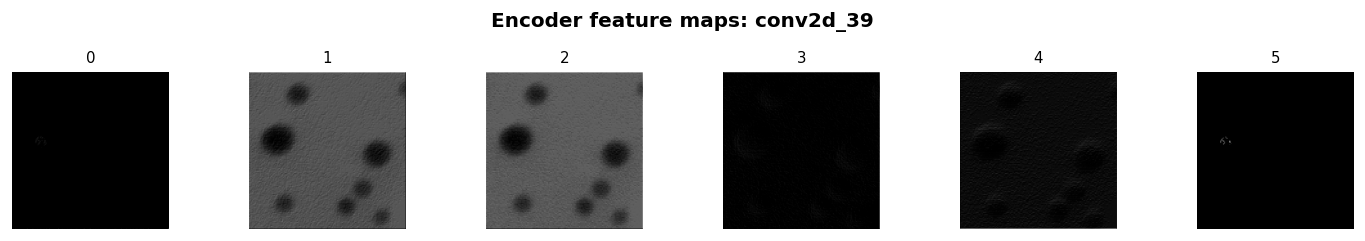

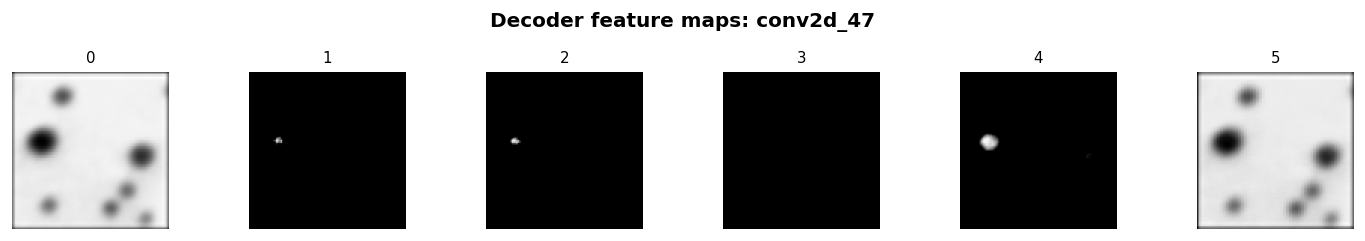

In [137]:
# Intermediate feature maps
from tensorflow.keras.models import Model

ENC_LAYER_NAME = "conv2d_39"
DEC_LAYER_NAME = "conv2d_47"

# Build feature-map model
feat_model = Model(
    inputs=unet_model.input,
    outputs=[
        unet_model.get_layer(ENC_LAYER_NAME).output,
        unet_model.get_layer(DEC_LAYER_NAME).output,
    ],
)

# Build a single input sample WITHOUT relying on x_train/val vars
rep_path = image_paths[0]
img = load_grayscale_float01(rep_path)

# Match model input size automatically
H, W = unet_model.input_shape[1], unet_model.input_shape[2]
img_resized = tf.image.resize(img[..., None], (H, W))  # (H,W,1)
x_sample = img_resized[None, ...]  # (1,H,W,1)

enc_act, dec_act = feat_model.predict(x_sample, verbose=0)
enc_act = enc_act[0]  # (H,W,C)
dec_act = dec_act[0]

def show_feature_maps(act, title, n=6):
    n = min(n, act.shape[-1])
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    fig.suptitle(title, fontsize=12, fontweight="bold")
    for i in range(n):
        axes[i].imshow(act[..., i], cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"{i}", fontsize=9)
    plt.tight_layout()
    plt.show()

show_feature_maps(enc_act, f"Encoder feature maps: {ENC_LAYER_NAME}", n=6)
show_feature_maps(dec_act, f"Decoder feature maps: {DEC_LAYER_NAME}", n=6)

Early encoder feature maps capture low-level edge and intensity patterns. Decoder feature maps show increasingly localized activations corresponding to particle regions, reflecting the integration of multi-scale features through skip connection sin the U-Net architecture.

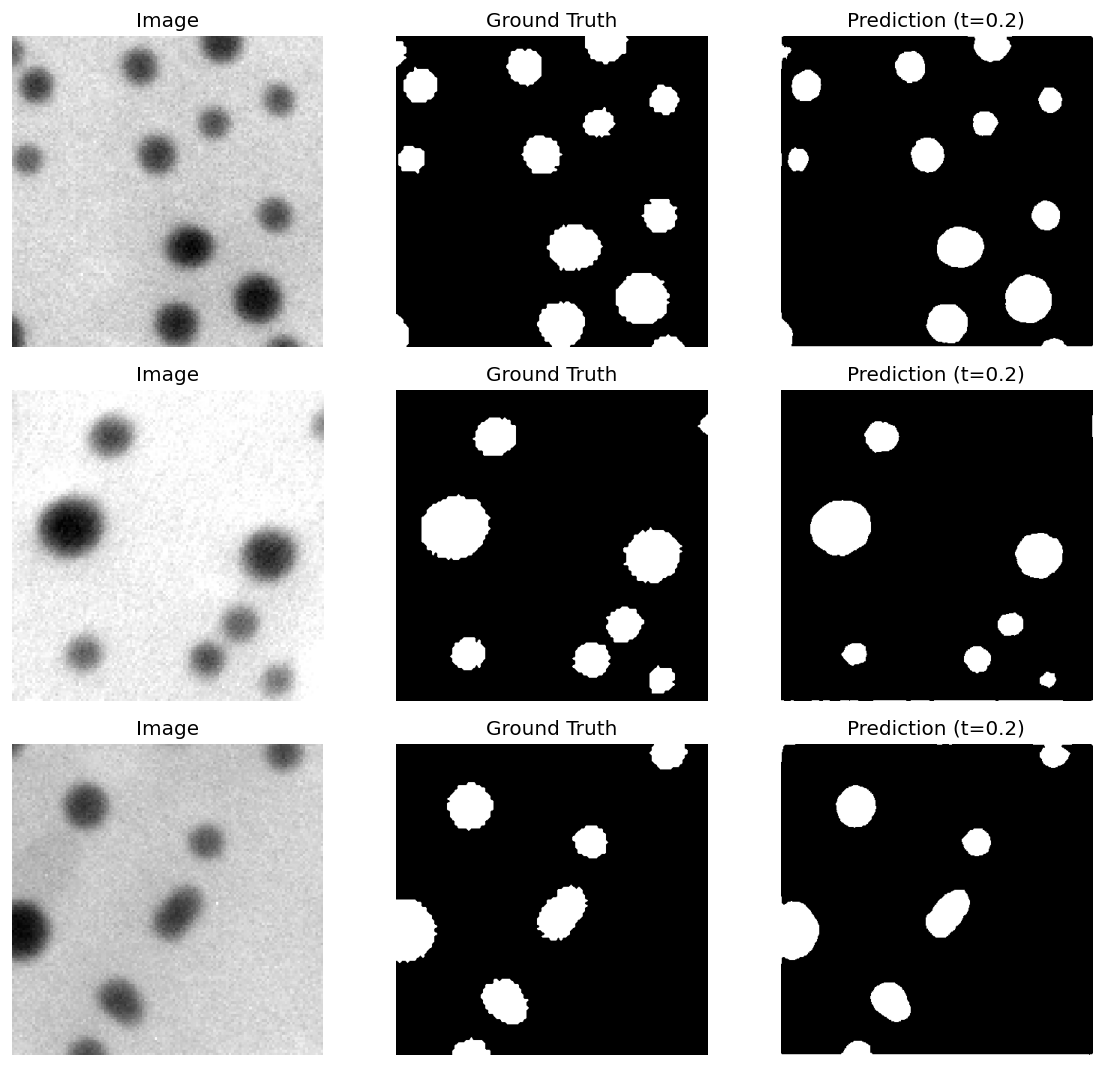

Saved: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\unet_results.png


In [50]:
# Full visualization of U-Net results
import matplotlib.pyplot as plt
import numpy as np

THRESH = 0.20 # as established earlier

for imgs, masks in val_ds.take(1):
    preds = unet_model.predict(imgs, verbose=0)
    preds_bin = (preds > THRESH).astype(np.uint8)

fig = plt.figure(figsize=(10, 9))
for i in range(3):
    # Image
    ax = plt.subplot(3, 3, 3*i + 1)
    ax.imshow(imgs[i,...,0], cmap="gray")
    ax.set_title("Image")
    ax.axis("off")

    # Ground truth
    ax = plt.subplot(3, 3, 3*i + 2)
    ax.imshow(masks[i,...,0], cmap="gray")
    ax.set_title("Ground Truth")
    ax.axis("off")

    # Prediction
    ax = plt.subplot(3, 3, 3*i + 3)
    ax.imshow(preds_bin[i,...,0], cmap="gray")
    ax.set_title(f"Prediction (t={THRESH})")
    ax.axis("off")

plt.tight_layout()
panel_path = OUT_DIR / "unet_results.png"
plt.savefig(panel_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", panel_path.resolve())

### Part D. Combined Figure & Assignment Summary

In [51]:
# Import/confirm libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

print("Libraries imported.")

Libraries imported.


In [58]:
# Define images and plots for 3 x 3 panel figure

# Representative image
rep_path = image_paths[0]
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
img_clahe = apply_clahe(img_den, clip_limit=0.02)
labels_ws = segment_otsu_watershed_dark_particles(img_den)
df_rep = measure_particles(labels_ws, img_den)

# Confusion matrix
def plot_confusion_ax(ax, y_true, y_pred, title,
                      class_names=("Class 0", "Class 1"),
                      cmap="Blues",
                      show_colorbar=False):
    """
    Draw a confusion matrix into an existing matplotlib axis.
    Colors show row-normalized rates; text shows raw counts.
    """
    cm = confusion_matrix(y_true, y_pred)
    # avoid divide-by-zero if a class is missing
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm, row_sums, where=row_sums != 0)

    im = ax.imshow(cm_norm, cmap=cmap, vmin=0, vmax=1)

    # annotate with raw counts
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=10)

    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names, rotation=0)
    ax.set_yticklabels(class_names, rotation=0)

    if show_colorbar:
        # attach colorbar to this axis
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    return im

# PCA + kmeans for display
# Safety: make sure these exist
assert "X_final_scaled" in globals(), "X_final_scaled not found — run Task 2 first."
# X_final_scaled should be (n_regions, n_selected_features)

# PCA just for visualization
pca2 = PCA(n_components=2, random_state=0)
X_pca = pca2.fit_transform(X_final_scaled)

# Evaluate k-means in feature space
k_values = [3, 5, 7]
sil_scores = {}
labels_k_store = {}

for k in k_values:
    km = KMeans(n_clusters=k, random_state=0, n_init=20)
    lab = km.fit_predict(X_final_scaled)  # fit in full feature space
    sil = silhouette_score(X_final_scaled, lab)  # score in full feature space
    sil_scores[k] = sil
    labels_k_store[k] = lab

# Choose what to show:
if "ml_summary" in globals() and "best_k_by_silhouette" in ml_summary.columns:
    K_SHOW = int(ml_summary.loc[0, "best_k_by_silhouette"])
    if K_SHOW not in labels_k_store:
        # if ml_summary best_k isn't in [3,5,7], fall back
        K_SHOW = max(sil_scores, key=sil_scores.get)
else:
    K_SHOW = max(sil_scores, key=sil_scores.get)

k_labels = labels_k_store[K_SHOW]
k_sil = sil_scores[K_SHOW]

# Performance numbers
svm_f1_val = svm_f1 if "svm_f1" in globals() else np.nan
rf_f1_val = rf_f1 if "rf_f1" in globals() else np.nan

unet_dice = results[1] if "results" in globals() and len(results) > 1 else np.nan
unet_iou  = results[2] if "results" in globals() and len(results) > 2 else np.nan

watershed_score = np.nan
if "snr_summary" in globals():
    watershed_score = float(snr_summary["delta_snr"].mean())

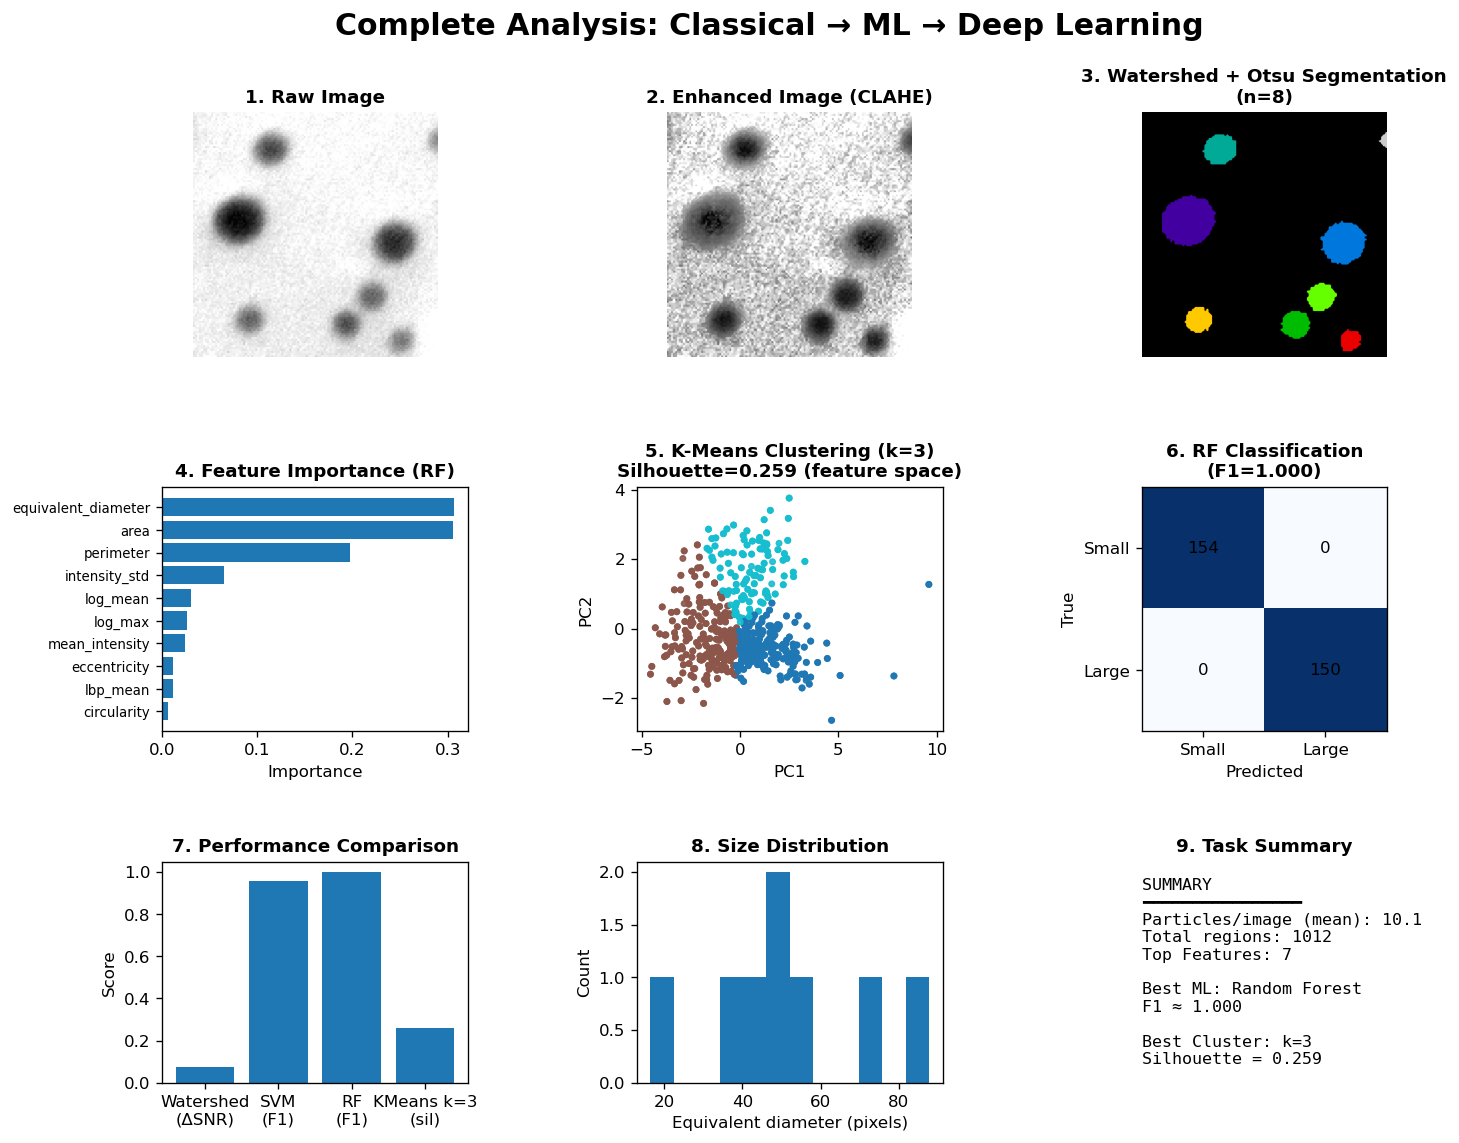

Saved: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\assignment_04_output\complete_analysis_3x3.png


In [59]:
# Combine elements to create 3 x 3 panel figure
fig = plt.figure(figsize=(13.5, 10.5))
gs = GridSpec(
    3, 3, figure=fig,
    height_ratios=[1.05, 1.05, 0.95],
    wspace=0.55, hspace=0.55
)

fig.suptitle("Complete Analysis: Classical → ML → Deep Learning", fontsize=18, fontweight="bold", y=0.96)

# 1) Raw
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img, cmap="gray")
ax1.set_title("1. Raw Image", fontsize=11, fontweight="bold")
ax1.axis("off")

# 2) CLAHE
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_clahe, cmap="gray")
ax2.set_title("2. Enhanced Image (CLAHE)", fontsize=11, fontweight="bold")
ax2.axis("off")

# 3) Watershed + Otsu
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(labels_ws, cmap="nipy_spectral")
ax3.set_title(f"3. Watershed + Otsu Segmentation\n(n={labels_ws.max()})", fontsize=11, fontweight="bold")
ax3.axis("off")

# 4) Feature importance
ax4 = fig.add_subplot(gs[1, 0])
topN = min(10, len(feat_importance))
fi = feat_importance.head(topN).iloc[::-1]
ax4.barh(fi["feature"], fi["importance"])
ax4.set_title("4. Feature Importance (RF)", fontsize=11, fontweight="bold")
ax4.set_xlabel("Importance")
ax4.tick_params(axis="y", labelsize=8)

# 5) KMeans PCA scatter
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(X_pca[:, 0], X_pca[:, 1], c=k_labels, cmap="tab10", s=10, alpha=0.9)
ax5.set_title(f"5. K-Means Clustering (k={K_SHOW})\nSilhouette={k_sil:.3f} (feature space)", fontsize=11, fontweight="bold")
ax5.set_xlabel("PC1")
ax5.set_ylabel("PC2")

# 6) Confusion matrix
ax6 = fig.add_subplot(gs[1, 2])
plot_confusion_ax(
    ax6,
    y_test,
    y_pred_rf,
    title=f"6. RF Classification\n(F1={rf_f1_val:.3f})",
    class_names=("Small", "Large"),   # matches Task 2 labels
    show_colorbar=False
)

# 7) Performance comparison
ax7 = fig.add_subplot(gs[2, 0])
labels_perf = ["Watershed\n(ΔSNR)", "SVM\n(F1)", "RF\n(F1)", f"KMeans k={K_SHOW}\n(sil)"]
vals_perf = [watershed_score, svm_f1_val, rf_f1_val, k_sil]
ax7.bar(range(len(vals_perf)), vals_perf)
ax7.set_xticks(range(len(vals_perf)))
ax7.set_xticklabels(labels_perf, rotation=0)
ax7.set_ylim(0, 1.05)
ax7.set_title("7. Performance Comparison", fontsize=11, fontweight="bold")
ax7.set_ylabel("Score")

# 8) Size distribution
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(df_rep["equivalent_diameter"], bins=12)
ax8.set_title("8. Size Distribution", fontsize=11, fontweight="bold")
ax8.set_xlabel("Equivalent diameter (pixels)")
ax8.set_ylabel("Count")

# 9) Summary text
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis("off")

mean_particles_per_image = df_feat.groupby("image_name").size().mean()

summary_lines = f"""
SUMMARY 
━━━━━━━━━━━━━━━━
Particles/image (mean): {mean_particles_per_image:.1f}
Total regions: {len(df_feat)}
Top Features: 7

Best ML: Random Forest
F1 ≈ {rf_f1_val:.3f}

Best Cluster: k={K_SHOW}
Silhouette = {k_sil:.3f}
"""

ax9.text(0.1, 0.5, summary_lines, fontsize=10, family='monospace', verticalalignment='center')
ax9.set_title('9. Task Summary', fontsize=11, fontweight='bold')

# Final save
panel_path = OUT_DIR / "complete_analysis_3x3.png"
plt.savefig(panel_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", panel_path.resolve())

#### See GitHub Repository for finalized assignment, imported figures, and updated README.md.